<a href="https://colab.research.google.com/github/gbangout-apziva/forecasting_stockprice/blob/main/forecasting_stockprice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock price forecastiing

We establish here, a robust intelligent system to aid the company's value investing efforts using stock market data. The work contains two main steps. The first step is to build a model to forecast prices. The second step is to build a recommender system to recommend to the company either to Buy, Sell or to Hold.

In [138]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [252]:
#!pip install pmdarima

## Loading relevant libraries

In [141]:
#!pip install pmdarima

In [142]:
#import necessary libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import time
import datetime
from datetime import datetime
from tqdm import tqdm_notebook
%matplotlib inline
# any plot will be in this notebook not in another open window
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
#keras
from keras.models import Sequential
from keras.metrics import MeanSquaredError
from keras.layers import Dense, GRU, LSTM
from tensorflow.keras.optimizers import SGD
#recommendation
from imblearn.combine import SMOTETomek
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.utils import to_categorical
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
import sys
from keras.layers import BatchNormalization
from hyperopt.pyll.base import scope
from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD, Adam, RMSprop 
from keras.callbacks import EarlyStopping
import statsmodels.api
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from termcolor import colored
from imblearn.under_sampling import TomekLinks

In [140]:
import pmdarima as pm
from pmdarima import model_selection

## Data Preparation

In [144]:
src="/content/drive/MyDrive/colabnotes/forecasting/"
file="2020Q1Q2Q3Q4-2021Q1 - Russia - Sberbank Rossii PAO (SBER).csv"
df_russia=pd.read_csv(src+file)
df_russia.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
0,"Mar 31, 2021",291.02,294,294.42,290.26,47.00M,-0.76%
1,"Mar 30, 2021",293.25,294.86,295.72,291.5,38.81M,-0.02%
2,"Mar 29, 2021",293.3,289.72,294.09,289.26,43.68M,0.71%
3,"Mar 26, 2021",291.22,288.63,292.75,288.32,56.07M,1.59%
4,"Mar 25, 2021",286.66,286.5,287.03,283.85,35.22M,0.30%


  Meaning of the features
* Open: the price the stock opened at
* High: the highest price during the day
* Low: the lowest price during the day
* Price: the closing price on the trading day
* Vol.: Volume – how many shares were traded
* changes %: is the percentage of changes between the cuurent day and the previous day



In [145]:
df_russia.tail(5)

,Date,Price,Open,High,Low,Vol.,Change %
307,"Jan 09, 2020",257.99,259.4,261.76,257.01,38.33M,-0.45%
308,"Jan 08, 2020",259.15,253.57,259.15,253.03,40.82M,2.07%
309,"Jan 06, 2020",253.9,254.75,254.84,251.4,22.35M,-0.43%
310,"Jan 03, 2020",255,255.99,258.19,253.7,35.85M,0.10%
311,Highest: 296.07,Lowest: 172.15,Difference: 123.92,Average: 234.52,Change %: 14.24,NaN,NaN


In [146]:
#removing the last row
df_russia=df_russia.drop(df_russia.index[len(df_russia)-1])

In [147]:
#replacing M in the volume column
df_russia.rename(columns = {'Vol.': 'Volume'}, inplace = True)
df_russia["Volume"]=df_russia.Volume.str.replace('M','')

#replace % value
df_russia["Change %"]=df_russia["Change %"].str.replace('%','').astype({'Change %':'float'})
df_russia["Change %"]=df_russia["Change %"].div(100)

In [148]:
df_russia.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 311 entries, 0 to 310
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      311 non-null    object 
 1   Price     311 non-null    object 
 2   Open      311 non-null    object 
 3   High      311 non-null    object 
 4   Low       311 non-null    object 
 5   Volume    311 non-null    object 
 6   Change %  311 non-null    float64
dtypes: float64(1), object(6)
memory usage: 19.4+ KB


In [149]:
df_russia.head()

,Date,Price,Open,High,Low,Volume,Change %
0,"Mar 31, 2021",291.02,294,294.42,290.26,47.00,-0.0076
1,"Mar 30, 2021",293.25,294.86,295.72,291.5,38.81,-0.0002
2,"Mar 29, 2021",293.3,289.72,294.09,289.26,43.68,0.0071
3,"Mar 26, 2021",291.22,288.63,292.75,288.32,56.07,0.0159
4,"Mar 25, 2021",286.66,286.5,287.03,283.85,35.22,0.0030


In [150]:
#function to convert Date column to datetime format
def mdy_to_ymd(d):
    return datetime.strptime(d, '%b %d, %Y').strftime('%Y-%m-%d')

In [151]:
d= df_russia['Date'][0]
mdy_to_ymd(d)

'2021-03-31'

In [152]:
df_russia['Date'] = df_russia.apply(lambda x: mdy_to_ymd(x['Date']), axis=1)

In [153]:
df_russia

,Date,Price,Open,High,Low,Volume,Change %
0,2021-03-31,291.02,294,294.42,290.26,47.00,-0.0076
1,2021-03-30,293.25,294.86,295.72,291.5,38.81,-0.0002
2,2021-03-29,293.3,289.72,294.09,289.26,43.68,0.0071
3,2021-03-26,291.22,288.63,292.75,288.32,56.07,0.0159
4,2021-03-25,286.66,286.5,287.03,283.85,35.22,0.0030
...,...,...,...,...,...,...,...
306,2020-01-10,258.19,257.86,259.25,256.88,18.85,0.0008
307,2020-01-09,257.99,259.4,261.76,257.01,38.33,-0.0045
308,2020-01-08,259.15,253.57,259.15,253.03,40.82,0.0207
309,2020-01-06,253.9,254.75,254.84,251.4,22.35,-0.0043


In [154]:
df_russia["Date"]=pd.to_datetime(df_russia.Date,format="%Y-%m-%d")

In [155]:
df_russia.set_index('Date',inplace=True)

In [156]:
df_russia.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 311 entries, 2021-03-31 to 2020-01-03
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     311 non-null    object 
 1   Open      311 non-null    object 
 2   High      311 non-null    object 
 3   Low       311 non-null    object 
 4   Volume    311 non-null    object 
 5   Change %  311 non-null    float64
dtypes: float64(1), object(5)
memory usage: 17.0+ KB


convert object features to float64 

In [157]:
df_russia=df_russia.astype({'Price':'float','Open':'float','High':'float','Low':'float','Volume':'float'})

In [158]:
#check the absence of missing values in the dataframe
df_russia.isnull().sum()

Price       0
Open        0
High        0
Low         0
Volume      0
Change %    0
dtype: int64

Checking statistics such as the mean, median, min, max and standard deviation values for our features.

In [159]:
df_russia.describe()

,Price,Open,High,Low,Volume,Change %
count,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000
mean,234.524019,234.417846,237.314759,231.366141,73.056977,0.000668
std,32.079847,32.058167,32.075624,32.076603,38.058095,0.021931
min,174.270000,175.000000,182.200000,172.150000,8.760000,-0.095700
25%,207.700000,207.215000,209.660000,204.475000,47.670000,-0.010100
50%,229.140000,229.080000,231.950000,226.860000,66.260000,0.000400
75%,264.380000,263.885000,267.255000,261.110000,85.120000,0.012950
max,293.300000,294.860000,296.070000,291.500000,263.040000,0.129000


# Data visualisation

In [160]:
df_russia.index

DatetimeIndex(['2021-03-31', '2021-03-30', '2021-03-29', '2021-03-26',
               '2021-03-25', '2021-03-24', '2021-03-23', '2021-03-22',
               '2021-03-19', '2021-03-18',
               ...
               '2020-01-17', '2020-01-16', '2020-01-15', '2020-01-14',
               '2020-01-13', '2020-01-10', '2020-01-09', '2020-01-08',
               '2020-01-06', '2020-01-03'],
              dtype='datetime64[ns]', name='Date', length=311, freq=None)

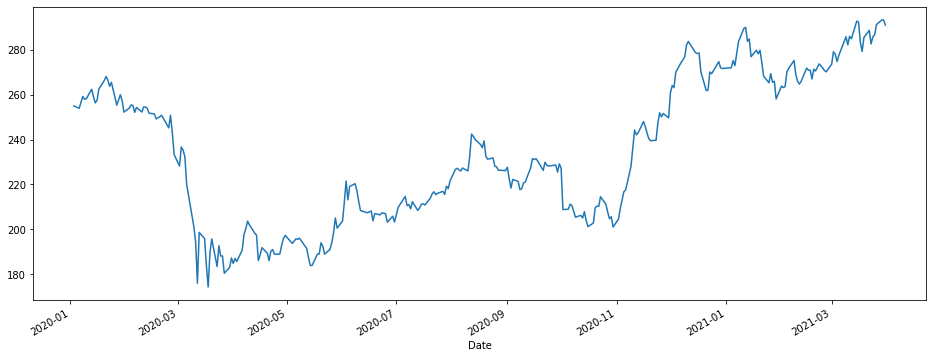

In [161]:
# price distribution over time
df_russia["Price"].plot(figsize=(16,6))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7619dd4430>,
      dtype=object)

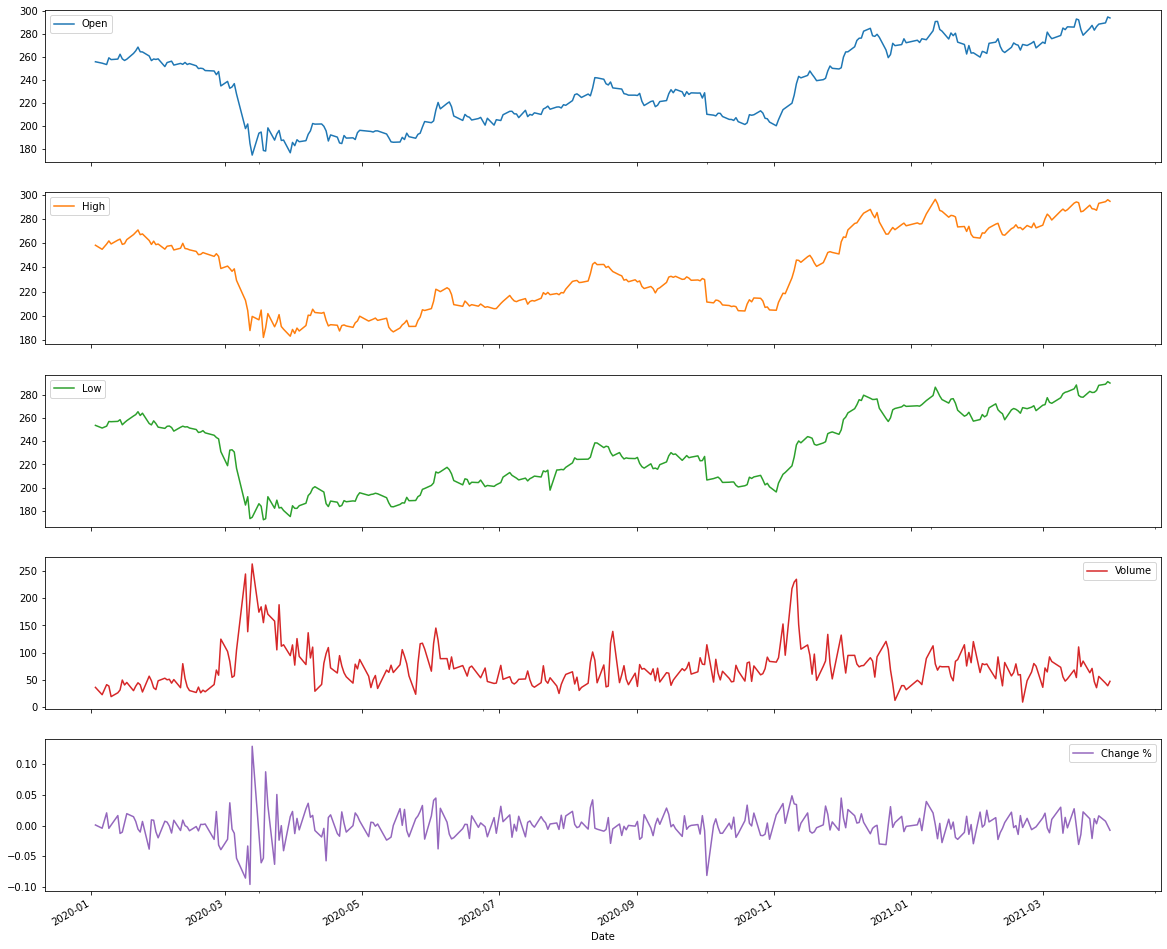

In [162]:
# distribution of other features
df_russia[['Open', 'High', 'Low', 'Volume', 'Change %']].plot(figsize=(20,18),subplots=True)

* compared to previous year, the stock’s daily closing price has increased in the first quarter of the year of 2021

In [163]:
# Boxplot of year and seasonality trend
# first make a new columns for the months and the year
#add year column
df_russia['year'] = [d.year for d in df_russia.index]
years = df_russia['year'].unique()
#add month column
df_russia['month'] = [d.month for d in df_russia.index]
months = df_russia['month'].unique()

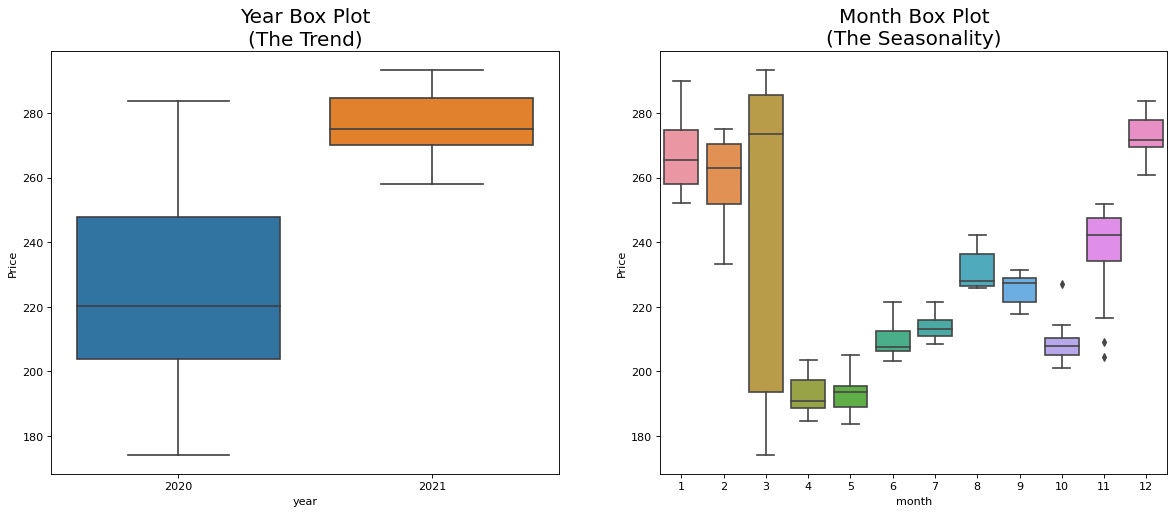

In [164]:
# Draw year_wise and month_wise box plots
fig, axes = plt.subplots(1, 2, figsize=(18,7), dpi= 80)
sns.boxplot(x='year', y='Price', data=df_russia, ax=axes[0])
sns.boxplot(x='month', y='Price', data=df_russia)

# Set Title
axes[0].set_title('Year Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

* Yearly boxplot show that the year of 2020 has a higher variance. We have just the first quarter in 2021.
* The monthly boxplots show that the month of March has higher variation in stock price as well as the highest value comparing to other months. 


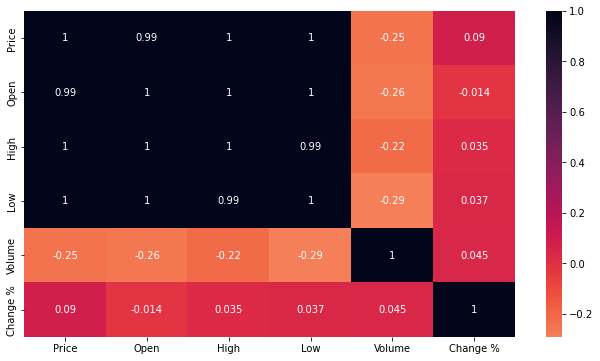

In [165]:
#plot the dataset feature map
plt.figure(figsize=(11,6)) # resizing the plot
sns.heatmap(df_russia.drop(['year','month'],axis=1).corr(),annot=True, cmap=sns.cm.rocket_r, center=0.117)

* Price has a very high positive correlation with the High and the Low features. Similarly for the Open feature. 

# PRICE FORECASTING

We tested two deep learning models:
* LSTM model
* GRU model

## Deep learning model (LSTM)

Here, we want to perform a multivariate prediction. So let's add some essential features like lag values of available numeric features widely accepted for time series problems, using the mean and the standard deviation of their lagged values. The following three sets of lagged values are used: one previous day, one looking back seven days and another looking back 30 days as a proxy for last week and last month metrics.

In [166]:
df1_russia=df_russia.copy()
df1_russia

,Price,Open,High,Low,Volume,Change %,year,month
Date,,,,,,,,
2021-03-31,291.02,294.00,294.42,290.26,47.00,-0.0076,2021,3
2021-03-30,293.25,294.86,295.72,291.50,38.81,-0.0002,2021,3
2021-03-29,293.30,289.72,294.09,289.26,43.68,0.0071,2021,3
2021-03-26,291.22,288.63,292.75,288.32,56.07,0.0159,2021,3
2021-03-25,286.66,286.50,287.03,283.85,35.22,0.0030,2021,3
...,...,...,...,...,...,...,...,...
2020-01-10,258.19,257.86,259.25,256.88,18.85,0.0008,2020,1
2020-01-09,257.99,259.40,261.76,257.01,38.33,-0.0045,2020,1
2020-01-08,259.15,253.57,259.15,253.03,40.82,0.0207,2020,1


In [167]:
df1_russia.drop(['month','year'],axis=1,inplace=True)

In [168]:
df1_russia

,Price,Open,High,Low,Volume,Change %
Date,,,,,,
2021-03-31,291.02,294.00,294.42,290.26,47.00,-0.0076
2021-03-30,293.25,294.86,295.72,291.50,38.81,-0.0002
2021-03-29,293.30,289.72,294.09,289.26,43.68,0.0071
2021-03-26,291.22,288.63,292.75,288.32,56.07,0.0159
2021-03-25,286.66,286.50,287.03,283.85,35.22,0.0030
...,...,...,...,...,...,...
2020-01-10,258.19,257.86,259.25,256.88,18.85,0.0008
2020-01-09,257.99,259.40,261.76,257.01,38.33,-0.0045
2020-01-08,259.15,253.57,259.15,253.03,40.82,0.0207


In [169]:
df1_russia.reset_index(inplace=True)
lag_features = ["Volume", "Change %",'Low','High','Open']
window1 = 3
window2 = 7
window3 = 30

df_rolled_3d = df1_russia[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = df1_russia[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df1_russia[lag_features].rolling(window=window3, min_periods=0)

df_mean_3d = df_rolled_3d.mean().shift(1).reset_index()
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index()
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index()

df_std_3d = df_rolled_3d.std().shift(1).reset_index()
df_std_7d = df_rolled_7d.std().shift(1).reset_index()
df_std_30d = df_rolled_30d.std().shift(1).reset_index()

for feature in lag_features:
    df1_russia[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    df1_russia[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    df1_russia[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]
    
    df1_russia[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    df1_russia[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    df1_russia[f"{feature}_std_lag{window3}"] = df_std_30d[feature]
    
#drop null variables
df1_russia.fillna(df1_russia.mean(), inplace=True)

df1_russia.set_index("Date", drop=True, inplace=True)
df1_russia

,Price,Open,High,Low,Volume,Change %,Volume_mean_lag3,Volume_mean_lag7,Volume_mean_lag30,Volume_std_lag3,...,High_mean_lag30,High_std_lag3,High_std_lag7,High_std_lag30,Open_mean_lag3,Open_mean_lag7,Open_mean_lag30,Open_std_lag3,Open_std_lag7,Open_std_lag30
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-31,291.02,294.00,294.42,290.26,47.00,-0.0076,73.232253,73.319982,73.889934,17.822796,...,238.655843,2.792781,4.401125,9.682551,234.476602,234.701885,235.750501,3.152489,4.713972,9.897364
2021-03-30,293.25,294.86,295.72,291.50,38.81,-0.0002,47.000000,47.000000,47.000000,17.822796,...,294.420000,2.792781,4.401125,9.682551,294.000000,294.000000,294.000000,3.152489,4.713972,9.897364
2021-03-29,293.30,289.72,294.09,289.26,43.68,0.0071,42.905000,42.905000,42.905000,5.791205,...,295.070000,0.919239,0.919239,0.919239,294.430000,294.430000,294.430000,0.608112,0.608112,0.608112
2021-03-26,291.22,288.63,292.75,288.32,56.07,0.0159,43.163333,43.163333,43.163333,4.119373,...,294.743333,0.861762,0.861762,0.861762,292.860000,292.860000,292.860000,2.753107,2.753107,2.753107
2021-03-25,286.66,286.50,287.03,283.85,35.22,0.0030,46.186667,46.390000,46.390000,8.898844,...,294.245000,1.487358,1.220014,1.220014,291.070000,291.802500,291.802500,3.327176,3.086469,3.086469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-10,258.19,257.86,259.25,256.88,18.85,0.0008,35.450000,37.055714,40.636333,12.331233,...,258.969000,2.288690,3.639880,5.506719,259.763333,260.471429,256.989667,2.371926,3.213163,5.048228
2020-01-09,257.99,259.40,261.76,257.01,38.33,-0.0045,25.280000,34.308571,40.339333,6.160511,...,259.227667,2.095861,2.892850,5.322467,259.553333,259.380000,257.306667,2.561354,2.420090,4.778373
2020-01-08,259.15,253.57,259.15,253.03,40.82,0.0207,27.680000,35.527143,40.593000,9.866707,...,259.547333,1.664942,1.840334,5.169764,258.520000,258.837143,257.619000,0.793221,1.755285,4.588810


In [170]:
#attach DateTime features like: week, day, month, day_of_week
df1_russia["month"] = [d.month for d in df1_russia.index]
df1_russia["week"] = [d.week for d in df1_russia.index]
df1_russia["day"] = [d.day for d in df1_russia.index]
df1_russia["day_of_week"] = [d.dayofweek for d in df1_russia.index]

In [171]:
# Visualize the new added features
df1_russia.loc[:,'month':'day_of_week'].head(7)

,month,week,day,day_of_week
Date,,,,
2021-03-31,3,13,31,2
2021-03-30,3,13,30,1
2021-03-29,3,13,29,0
2021-03-26,3,12,26,4
2021-03-25,3,12,25,3
2021-03-24,3,12,24,2
2021-03-23,3,12,23,1


In [173]:
#select exogenous features
exogenous_features=df1_russia.columns[6:].values.tolist()
exogenous_features

['Volume_mean_lag3',
 'Volume_mean_lag7',
 'Volume_mean_lag30',
 'Volume_std_lag3',
 'Volume_std_lag7',
 'Volume_std_lag30',
 'Change %_mean_lag3',
 'Change %_mean_lag7',
 'Change %_mean_lag30',
 'Change %_std_lag3',
 'Change %_std_lag7',
 'Change %_std_lag30',
 'Low_mean_lag3',
 'Low_mean_lag7',
 'Low_mean_lag30',
 'Low_std_lag3',
 'Low_std_lag7',
 'Low_std_lag30',
 'High_mean_lag3',
 'High_mean_lag7',
 'High_mean_lag30',
 'High_std_lag3',
 'High_std_lag7',
 'High_std_lag30',
 'Open_mean_lag3',
 'Open_mean_lag7',
 'Open_mean_lag30',
 'Open_std_lag3',
 'Open_std_lag7',
 'Open_std_lag30',
 'month',
 'week',
 'day',
 'day_of_week']

In [172]:
df1_russia.isna().sum()

Price                  0
Open                   0
High                   0
Low                    0
Volume                 0
Change %               0
Volume_mean_lag3       0
Volume_mean_lag7       0
Volume_mean_lag30      0
Volume_std_lag3        0
Volume_std_lag7        0
Volume_std_lag30       0
Change %_mean_lag3     0
Change %_mean_lag7     0
Change %_mean_lag30    0
Change %_std_lag3      0
Change %_std_lag7      0
Change %_std_lag30     0
Low_mean_lag3          0
Low_mean_lag7          0
Low_mean_lag30         0
Low_std_lag3           0
Low_std_lag7           0
Low_std_lag30          0
High_mean_lag3         0
High_mean_lag7         0
High_mean_lag30        0
High_std_lag3          0
High_std_lag7          0
High_std_lag30         0
Open_mean_lag3         0
Open_mean_lag7         0
Open_mean_lag30        0
Open_std_lag3          0
Open_std_lag7          0
Open_std_lag30         0
month                  0
week                   0
day                    0
day_of_week            0


In [174]:
#split data into train and test
np.random.seed(5)
train_data = df1_russia[df1_russia.index < pd.to_datetime('2021-01-01', format="%Y-%m-%d")]
train_data=train_data.dropna()
test_data=df1_russia[df1_russia.index >= pd.to_datetime('2021-01-01', format="%Y-%m-%d")]
test_data=test_data.dropna()

In [175]:
print('shape of train set: ',train_data.shape)
print('shape of test set: ',test_data.shape)

shape of train set:  (250, 40)
shape of test set:  (61, 40)


In [176]:
train_lstm=train_data.copy()
test_lstm=test_data.copy()

In [177]:
def build_train_test_normalize(time_steps,for_periods):
    '''
    input: 
      time_steps and period to predict
    output:
      X_train, y_train: data from 2013/1/1-2018/12/31
      X_test:  data from 2019 -
      sc:      insantiated MinMaxScaler object fit to the training data
    '''
    np.random.seed(1)
    # create training and test set
    ts_train = train_lstm.iloc[:,0:1].values
    ts_test  = test_lstm.iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # scale the data
    from sklearn.preprocessing import MinMaxScaler
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)

    # create training data of s samples and t time steps
    X_train = []
    y_train = []
    y_train_stacked = []
    for i in range(time_steps,ts_train_len-1): 
        X_train.append(ts_train_scaled[i-time_steps:i,0])
        y_train.append(ts_train_scaled[i:i+for_periods,0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    inputs = pd.concat((train_lstm.iloc[:,0:1], test_lstm.iloc[:,0:1]),axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)
    inputs  = sc.transform(inputs)

    # Preparing X_test
    X_test = []
    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])
        
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test, sc

In [178]:
#choose a time step of 30 days and a prediod of 1 predictions
X_train, y_train, X_test, sc = build_train_test_normalize(30,1)
X_train.shape[0],X_train.shape[1]

(219, 30)

In [179]:
print("There are " + str(X_train.shape[0]) + " samples in the training data")
print("There are " + str(X_test.shape[0]) + " samples in the test data")

There are 219 samples in the training data
There are 60 samples in the test data


In [180]:
#define plot function 
def actual_vs_pred_plot(preds, data=test_lstm, plot=True):
    '''
    input: predictions from the RNN model
    output: mean square error value and the plot of real vs predicted values
    '''
    #define a new dataframe with price and prediction columns
    
    actual_pred = pd.DataFrame(columns = ['Price', 'prediction'])
    actual_pred['Price'] = data.iloc[:,0:1].iloc[0:len(preds)]
    actual_pred['prediction'] = preds[:,0]
    MAPE=np.mean(np.abs(np.array(actual_pred['prediction'])- np.array(actual_pred['Price']))/np.abs(np.array(actual_pred['Price'])))
    RMSE=math.sqrt(mean_squared_error(np.array(actual_pred['Price']), np.array(actual_pred['prediction'])))
    if plot==True:
        actual_pred.plot()
        plt.title('Stock Price Prediction')
        plt.xlabel('Time')
        plt.ylabel('Stock Price')
        plt.legend(loc='upper left', fontsize=8)
        plt.show()
    return MAPE,RMSE

In [181]:
#create a LSTM model
def LSTM_model_fc(X_train, y_train, X_test, sc, epoch=100, batch_size=32,optimizer='Adam',units=100):
    np.random.seed(1)
    # The LSTM architecture
    regressor = Sequential()
    # Adding first LSTM layer and some dropout Dropout regularisation
    regressor.add(LSTM(units=units, return_sequences=True, input_shape = (X_train.shape[1], 1)))
    regressor.add(Dropout(0.2))

    # Adding second LSTM layer and some dropout Dropout regularisation
    regressor.add(LSTM(units=units, return_sequences=True))
    regressor.add(Dropout(0.2))

    # Adding third LSTM layer and some dropout Dropout regularisation
    regressor.add(LSTM(units=units, return_sequences=True))
    regressor.add(Dropout(0.2))

    # Adding fourth LSTM layer and some dropout Dropout regularisation
    regressor.add(LSTM(units=units, return_sequences=True))
    regressor.add(Dropout(0.2))

    # Adding fifth LSTM layer and some dropout Dropout regularisation
    regressor.add(LSTM(units=units))
    regressor.add(Dropout(0.2))

    # Adding the Output Layer
    regressor.add(Dense(units=1))

    # Compiling the RNN
    # Because we're doing regression hence mean_squared_error
    regressor.compile(optimizer=optimizer, loss = 'mean_squared_error', metrics=['accuracy'])

    # Fitting the RNN to the Training set
    regressor.fit(X_train, y_train, epochs = epoch, batch_size = batch_size)
    
    LSTM_prediction = regressor.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return regressor, LSTM_prediction

In [182]:
np.random.seed(1)
#choose a time step of 30 days and a prediod of 1 predictions
X_train, y_train, X_test, sc = build_train_test_normalize(30,1)
X_train.shape[0],X_train.shape[1]
LSTM_model_before, LSTM_prediction_before = LSTM_model_fc(X_train, y_train, X_test, sc)

Epoch 1/100
7/7 [==============================] - 14s 132ms/step - loss: 0.1074 - accuracy: 0.0046
Epoch 2/100
7/7 [==============================] - 1s 126ms/step - loss: 0.0563 - accuracy: 0.0046
Epoch 3/100
7/7 [==============================] - 1s 127ms/step - loss: 0.0370 - accuracy: 0.0046
Epoch 4/100
7/7 [==============================] - 1s 123ms/step - loss: 0.0352 - accuracy: 0.0046
Epoch 5/100
7/7 [==============================] - 1s 127ms/step - loss: 0.0321 - accuracy: 0.0046
Epoch 6/100
7/7 [==============================] - 1s 120ms/step - loss: 0.0286 - accuracy: 0.0046
Epoch 7/100
7/7 [==============================] - 1s 119ms/step - loss: 0.0255 - accuracy: 0.0046
Epoch 8/100
7/7 [==============================] - 1s 130ms/step - loss: 0.0229 - accuracy: 0.0046
Epoch 9/100
7/7 [==============================] - 1s 122ms/step - loss: 0.0187 - accuracy: 0.0046
Epoch 10/100
7/7 [==============================] - 1s 122ms/step - loss: 0.0231 - accuracy: 0.0046
Epoch 11

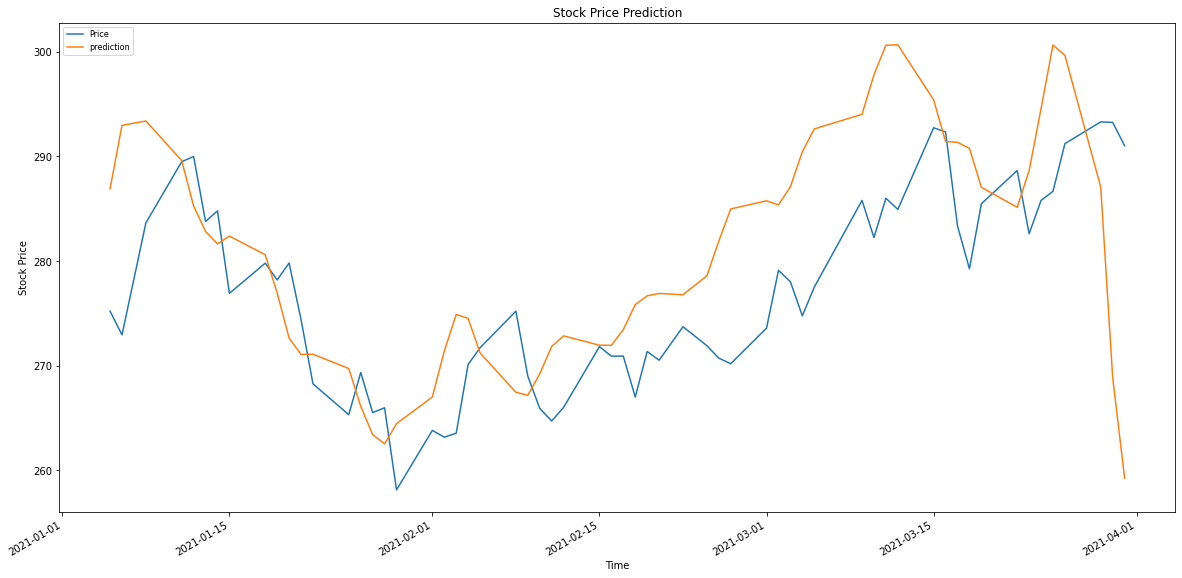

(0.026697972690422112, 9.633057810874293)

In [183]:
#Plot predictions
actual_vs_pred_plot(LSTM_prediction_before)   

In [185]:
print("The results of test data are: MAPE=0.026697972690422112 and RMSE=9.633057810874293")

The results of test data are: MAPE=0.026697972690422112 and RMSE=9.633057810874293


# GRU model

In [230]:
#create a GRU model
def GRU_model(X_train, y_train, X_test, sc):
    # The GRU architecture
    regressor = Sequential()
    # Adding first GRU layer and some dropout Dropout regularisation
    regressor.add(GRU(units=100, return_sequences=True, input_shape = (X_train.shape[1], 1)))
    regressor.add(Dropout(0.2))

    # Adding second GRU layer and some dropout Dropout regularisation
    regressor.add(GRU(units=100, return_sequences=True))
    regressor.add(Dropout(0.2))

    # Adding third GRU layer and some dropout Dropout regularisation
    regressor.add(GRU(units=100, return_sequences=True))
    regressor.add(Dropout(0.2))

    # Adding fourth GRU layer and some dropout Dropout regularisation
    regressor.add(GRU(units=100, return_sequences=True))
    regressor.add(Dropout(0.2))

    # Adding fifth GRU layer and some dropout Dropout regularisation
    regressor.add(GRU(units=100))
    regressor.add(Dropout(0.2))

    # Adding the Output Layer
    regressor.add(Dense(units=1))

    # Compiling the GRU
    # Because we're doing regression hence mean_squared_error
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])

    # Fitting the RNN to the Training set
    regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)
    
    GRU_prediction = regressor.predict(X_test)
    GRU_prediction = sc.inverse_transform(GRU_prediction)

    return regressor, GRU_prediction

In [231]:
np.random.seed(1)
GRU_model, GRU_predictions = GRU_model(X_train, y_train, X_test, sc)

Epoch 1/100
7/7 [==============================] - 10s 148ms/step - loss: 0.0822 - accuracy: 0.0048
Epoch 2/100
7/7 [==============================] - 1s 144ms/step - loss: 0.0306 - accuracy: 0.0048
Epoch 3/100
7/7 [==============================] - 1s 142ms/step - loss: 0.0192 - accuracy: 0.0048
Epoch 4/100
7/7 [==============================] - 1s 144ms/step - loss: 0.0144 - accuracy: 0.0048
Epoch 5/100
7/7 [==============================] - 1s 141ms/step - loss: 0.0125 - accuracy: 0.0048
Epoch 6/100
7/7 [==============================] - 1s 142ms/step - loss: 0.0108 - accuracy: 0.0048
Epoch 7/100
7/7 [==============================] - 1s 142ms/step - loss: 0.0097 - accuracy: 0.0048
Epoch 8/100
7/7 [==============================] - 1s 144ms/step - loss: 0.0092 - accuracy: 0.0048
Epoch 9/100
7/7 [==============================] - 1s 140ms/step - loss: 0.0088 - accuracy: 0.0048
Epoch 10/100
7/7 [==============================] - 1s 145ms/step - loss: 0.0088 - accuracy: 0.0048
Epoch 11

In [232]:
GRU_model.summary()

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 40, 100)           30900     
                                                                 
 dropout_240 (Dropout)       (None, 40, 100)           0         
                                                                 
 gru_1 (GRU)                 (None, 40, 100)           60600     
                                                                 
 dropout_241 (Dropout)       (None, 40, 100)           0         
                                                                 
 gru_2 (GRU)                 (None, 40, 100)           60600     
                                                                 
 dropout_242 (Dropout)       (None, 40, 100)           0         
                                                                 
 gru_3 (GRU)                 (None, 40, 100)         

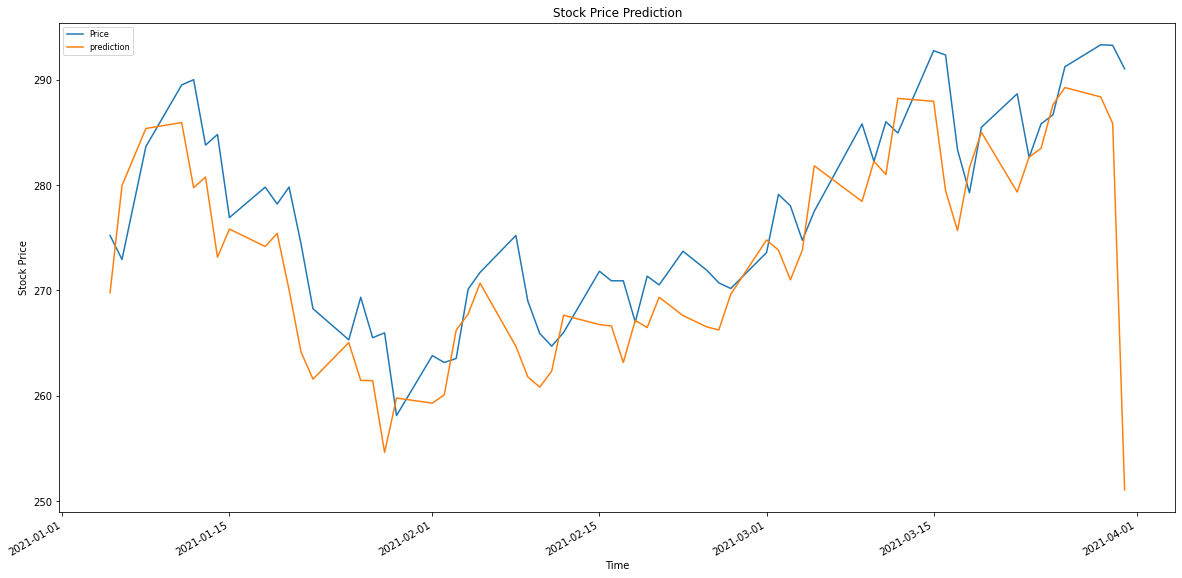

(0.018738884434152482, 7.6507620071505045)

In [233]:
#plot predictions
actual_vs_pred_plot(GRU_predictions)  

In [234]:
print("The results of test data are: MAPE=018738884434152482 and RMSE=7.6507620071505045")

The results of test data are: MAPE=018738884434152482 and RMSE=7.6507620071505045


# Build recommender system

In [237]:
y_train_pred=GRU_model.predict(X_train)
y_train_pred = sc.inverse_transform(y_train_pred)

7/7 [==============================] - 0s 39ms/step


In [240]:
label_stocks = pd.DataFrame(columns = ['real', 'lstm_pred','label'])
label_stocks['real'] = train_lstm.iloc[:,0:1].iloc[0:len(y_train_pred)]
label_stocks['lstm_pred'] = y_train_pred[:,0]

In [241]:
label_stocks=label_stocks.sort_values(by='Date') 
label_stocks.head(5)

,real,lstm_pred,label
Date,,,
2020-03-04,235.27,255.138977,NaN
2020-03-05,232.33,254.119125,NaN
2020-03-06,219.99,254.650299,NaN
2020-03-10,201.20,258.175903,NaN
2020-03-11,194.53,254.932831,NaN


In [242]:
# 0 hold , 1 buy, 2 sell
if label_stocks['lstm_pred'][0]> label_stocks['real'][0]:
    diff=1
else:
    diff=0

label_stocks["label"][0]='hold'
for i in range(1,label_stocks.shape[0]):
    if label_stocks['lstm_pred'][i]< label_stocks['real'][i] and diff==1:
        label_stocks["label"][i]='sell'
        diff=0
    elif label_stocks['lstm_pred'][i]> label_stocks['real'][i] and diff==0:
        label_stocks["label"][i]='buy'
        diff=1
        
    else:
        label_stocks["label"][i]='hold'

In [243]:
# recommendation of buy
label_stocks[label_stocks["label"]=='buy']

,real,lstm_pred,label
Date,,,
2020-05-08,196.02,198.846359,buy
2020-05-15,183.85,191.865952,buy
2020-10-02,208.80,224.006393,buy


In [244]:
# recommendation of sell
label_stocks[label_stocks["label"]=='sell']

,real,lstm_pred,label
Date,,,
2020-05-06,195.70,190.893005,sell
2020-05-13,187.31,182.170883,sell
2020-05-19,189.00,187.145706,sell
2020-11-09,228.05,225.463562,sell


In [245]:
label_stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 209 entries, 2020-03-04 to 2020-12-30
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   real       209 non-null    float64
 1   lstm_pred  209 non-null    float32
 2   label      209 non-null    object 
dtypes: float32(1), float64(1), object(1)
memory usage: 5.7+ KB


In [246]:
label_stocks.describe()

,real,lstm_pred
count,209.000000,209.000000
mean,218.341435,215.882034
std,25.175608,21.455690
min,174.270000,180.145599
25%,200.500000,199.444733
50%,212.530000,212.391556
75%,230.300000,228.631165
max,283.730000,264.160065


In [247]:
y=label_stocks['label']

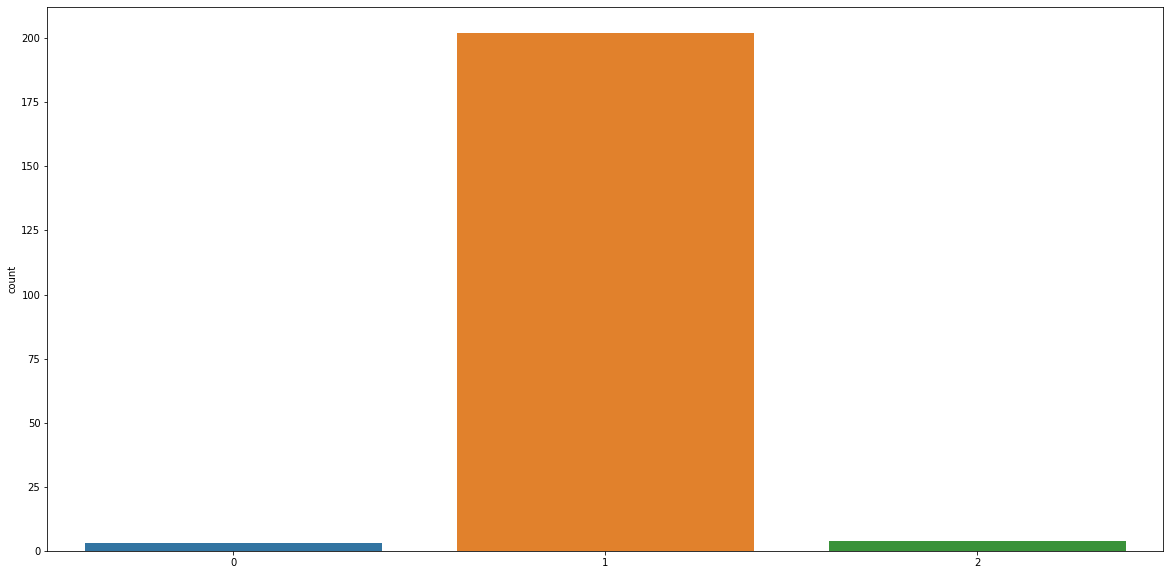

In [248]:
# Encoding categorical data
labelencoder = LabelEncoder()
Y = labelencoder.fit_transform(y) 
sns.countplot(Y)

In [249]:
label_stocks.head()

,real,lstm_pred,label
Date,,,
2020-03-04,235.27,255.138977,hold
2020-03-05,232.33,254.119125,hold
2020-03-06,219.99,254.650299,hold
2020-03-10,201.20,258.175903,hold
2020-03-11,194.53,254.932831,hold


### Treating imbalance dataset

## Conclusion: